## Problem Context

<img src=https://www.the-learning-agency.com/wp-content/uploads/2021/03/TLA_Labs_Color__LG.png>

Writing is a foundational skill. Sadly, it's one few students are able to hone, often because writing tasks are infrequently assigned in school. A rapidly growing student population, students learning English as a second language, known as English Language Learners (ELLs), are especially affected by the lack of practice. While automated feedback tools make it easier for teachers to assign more writing tasks, they are not designed with ELLs in mind.

Existing tools are unable to provide feedback based on the language proficiency of the student, resulting in a final evaluation that may be skewed against the learner. Data science may be able to improve automated feedback tools to better support the unique needs of these learners.

Competition host Vanderbilt University is a private research university in Nashville, Tennessee. It offers 70 undergraduate majors and a full range of graduate and professional degrees across 10 schools and colleges, all on a beautiful campus—an accredited arboretum—complete with athletic facilities and state-of-the-art laboratories. Vanderbilt is optimized to inspire and nurture cross-disciplinary research that fosters discoveries that have global impact. Vanderbilt and co-host, The Learning Agency Lab, an independent nonprofit based in Arizona, are focused on developing science of learning-based tools and programs for social good.

Vanderbilt and The Learning Agency Lab have partnered together to offer data scientists the opportunity to support ELLs using data science skills in machine learning, natural language processing, and educational data analytics. You can improve automated feedback tools for ELLs by sensitizing them to language proficiency. The resulting tools could serve teachers by alleviating the grading burden and support ELLs by ensuring their work is evaluated within the context of their current language level.

## Importing Necessary Dependancies

In [2]:
import re 
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from transformers import TFAutoModel, AutoTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_theme()
%matplotlib inline 

## Loading and Exploring Dataset

In [3]:
train_df = pd.read_csv('../input/feedback-prize-english-language-learning/train.csv')
test_df = pd.read_csv('../input/feedback-prize-english-language-learning/test.csv')

In [4]:
train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB


In [6]:
train_df.describe().style.background_gradient(cmap='Blues').set_properties(**{'font-family':'Segoe UI'})

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [7]:
train_df['full_text'][5]

"Dear Principal,\r\n\r\nOur school should have a community center. The reasons why, are so students can learn what our community needs, how to make our community better place, and why is community important for students to know. Its a great to have a community center to know how we can make things better.\r\n\r\nStudents think community center takes their time away. but they have to learn what our community needs. students will participate in a group of students making a list what our community needs, therefore students will learn what our community needs! students will present their list of things our community needs! due to that students will be giving extra credit for the ones who have low grades!\r\n\r\nSome students don't participate because their friends say its waste of time. it would not be waste of time when you get to know how our community can be a better place for us. students should know that the program is about our own lives, because if our community is bad well our live

## Text Cleaning

In [8]:
train_df['full_text'] = train_df["full_text"].replace(re.compile(r'[\n\r\t]'), '', regex=True)
test_df['full_text'] = test_df["full_text"].replace(re.compile(r'[\n\r\t]'), '', regex=True)

In [9]:
train_df['full_text'][5]

"Dear Principal,Our school should have a community center. The reasons why, are so students can learn what our community needs, how to make our community better place, and why is community important for students to know. Its a great to have a community center to know how we can make things better.Students think community center takes their time away. but they have to learn what our community needs. students will participate in a group of students making a list what our community needs, therefore students will learn what our community needs! students will present their list of things our community needs! due to that students will be giving extra credit for the ones who have low grades!Some students don't participate because their friends say its waste of time. it would not be waste of time when you get to know how our community can be a better place for us. students should know that the program is about our own lives, because if our community is bad well our lives are going to be bad. d

## Words Count Analysis

In [10]:
train_df['num_words'] = train_df['full_text'].apply(lambda x: len(x.split()))
avg_words = round(train_df['num_words'].mean())
max_words = round(train_df['num_words'].max())
print('Average length: {}'.format(avg_words))
print('Max length: {}'.format(max_words))

Average length: 426
Max length: 1250


<AxesSubplot:xlabel='num_words', ylabel='Density'>

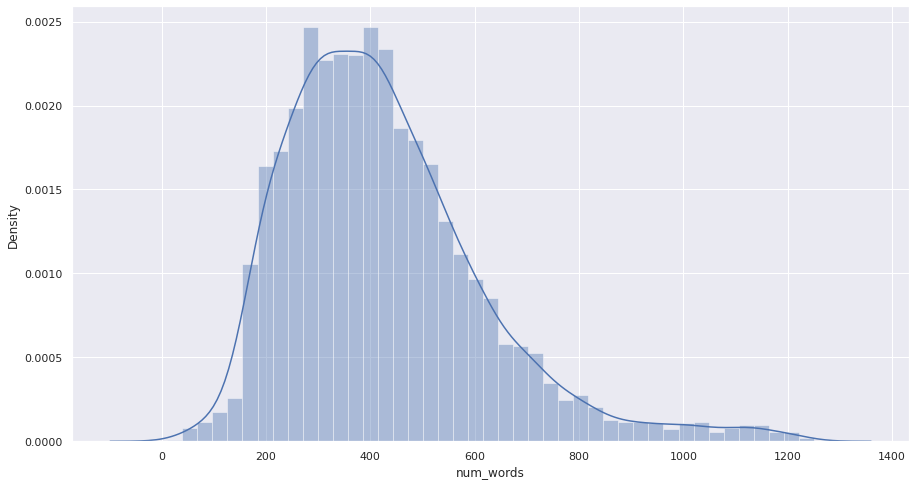

In [11]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.distplot(train_df['num_words'], kde=True)

## Scores Distribution

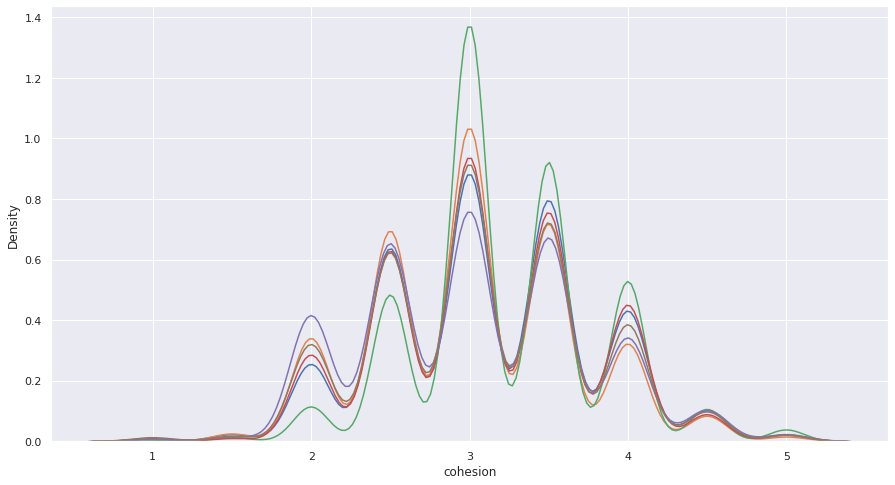

In [12]:
sns.set(rc = {'figure.figsize':(15,8)})

for col in train_df.drop(columns=['text_id', 'full_text', 'num_words']).columns:
    sns.kdeplot(train_df[col], legend=True)

## Plotting Words Cloud

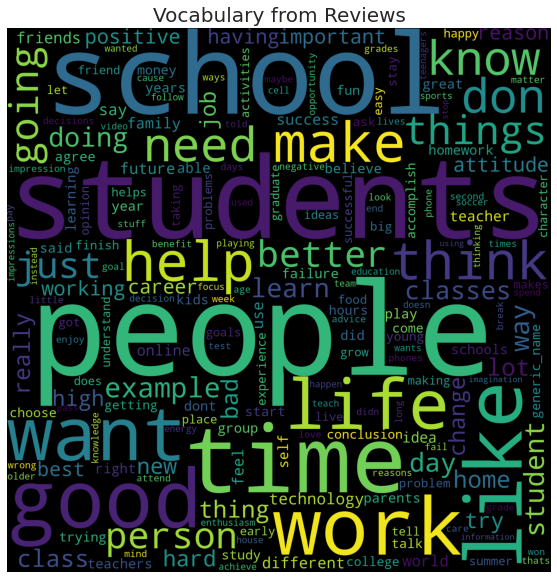

In [13]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train_df['full_text'])
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

wordcloud = WordCloud(width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Vocabulary from Reviews", fontsize = 20)
plt.show()

## Correlation Matrix

<AxesSubplot:>

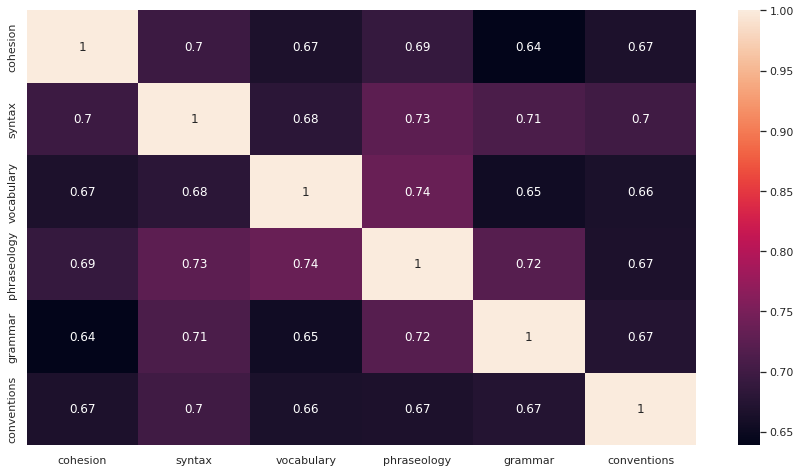

In [14]:
sns.heatmap(train_df.drop(columns=['text_id', 'full_text', 'num_words']).corr(), annot=True)

## Dataset Preparation

In [15]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['full_text'])
word_index = tokenizer.word_index

train_seq = tokenizer.texts_to_sequences(train_df['full_text'])
pad_train = pad_sequences(train_seq, maxlen=max_words, truncating='post')

test_seq = tokenizer.texts_to_sequences(test_df['full_text'])
pad_test = pad_sequences(test_seq, maxlen=max_words, truncating='post')

In [16]:
word_idx_count = len(word_index)
print(word_idx_count)

23007


In [17]:
X = pad_train
y = [train_df['cohesion'].values, train_df['syntax'].values, train_df['vocabulary'].values,
      train_df['phraseology'].values, train_df['grammar'].values, train_df['conventions'].values]

## Modeling with LSTM

Long short-term memory (LSTM) is an artificial neural network used in the fields of artificial intelligence and deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. Such a recurrent neural network (RNN) can process not only single data points (such as images), but also entire sequences of data (such as speech or video). For example, LSTM is applicable to tasks such as unsegmented, connected handwriting recognition, speech recognition, machine translation, robot control, video games, and healthcare. LSTM has become the most cited neural network of the 20th century.
 
 <img src=https://www.mdpi.com/sensors/sensors-21-05625/article_deploy/html/images/sensors-21-05625-g001.png width=800/>
 
The name of LSTM refers to the analogy that a standard RNN has both "long-term memory" and "short-term memory". The connection weights and biases in the network change once per episode of training, analogous to how physiological changes in synaptic strengths store long-term memories; the activation patterns in the network change once per time-step, analogous to how the moment-to-moment change in electric firing patterns in the brain store short-term memories. The LSTM architecture aims to provide a short-term memory for RNN that can last thousands of timesteps, thus "long short-term memory".
 
A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.
 
LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series. LSTMs were developed to deal with the vanishing gradient problem that can be encountered when training traditional RNNs. Relative insensitivity to gap length is an advantage of LSTM over RNNs, hidden Markov models and other sequence learning methods in numerous applications.
 
The compact forms of the equations for the forward pass of an LSTM cell with a forget gate are:
 
 <img src=https://wikimedia.org/api/rest_v1/media/math/render/svg/dc89390b3136ccbbc223a1ed110c6d2b4856069c width=300/>


In [42]:
def get_lstm_model():

    inputs = tf.keras.layers.Input(shape=(max_words))
    embeddings = tf.keras.layers.Embedding(word_idx_count + 1, 64, input_length=max_words)(inputs)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(embeddings)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)
    
    output1 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
                                    bias_initializer='zeros',
                                    kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), 
                                    bias_regularizer=tf.keras.regularizers.L2(1e-4), 
                                    activity_regularizer=tf.keras.regularizers.L2(1e-5))(x)
    output1 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
                                    bias_initializer='zeros',
                                    kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), 
                                    bias_regularizer=tf.keras.regularizers.L2(1e-4), 
                                    activity_regularizer=tf.keras.regularizers.L2(1e-5))(output1)
    output1 = tf.keras.layers.Dense(1, activation='relu', name='cohesion')(output1)
    
    
    output2 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
                                    bias_initializer='zeros',
                                    kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), 
                                    bias_regularizer=tf.keras.regularizers.L2(1e-4), 
                                    activity_regularizer=tf.keras.regularizers.L2(1e-5))(x)
    output2 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
                                    bias_initializer='zeros',
                                    kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), 
                                    bias_regularizer=tf.keras.regularizers.L2(1e-4), 
                                    activity_regularizer=tf.keras.regularizers.L2(1e-5))(output2)
    output2 = tf.keras.layers.Dense(1, activation='relu', name='syntax')(output2)
    
    output3 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
                                    bias_initializer='zeros',
                                    kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), 
                                    bias_regularizer=tf.keras.regularizers.L2(1e-4), 
                                    activity_regularizer=tf.keras.regularizers.L2(1e-5))(x)
    output3 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
                                    bias_initializer='zeros',
                                    kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), 
                                    bias_regularizer=tf.keras.regularizers.L2(1e-4), 
                                    activity_regularizer=tf.keras.regularizers.L2(1e-5))(output3)
    output3 = tf.keras.layers.Dense(1, activation='relu', name='vocabulary')(output3)
    
    output4 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
                                    bias_initializer='zeros',
                                    kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), 
                                    bias_regularizer=tf.keras.regularizers.L2(1e-4), 
                                    activity_regularizer=tf.keras.regularizers.L2(1e-5))(x)
    output4 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
                                    bias_initializer='zeros',
                                    kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), 
                                    bias_regularizer=tf.keras.regularizers.L2(1e-4), 
                                    activity_regularizer=tf.keras.regularizers.L2(1e-5))(output4)
    output4 = tf.keras.layers.Dense(1, activation='relu', name='phraseology')(output4)
    
    output5 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
                                    bias_initializer='zeros',
                                    kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), 
                                    bias_regularizer=tf.keras.regularizers.L2(1e-4), 
                                    activity_regularizer=tf.keras.regularizers.L2(1e-5))(x)
    output5 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
                                    bias_initializer='zeros',
                                    kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), 
                                    bias_regularizer=tf.keras.regularizers.L2(1e-4), 
                                    activity_regularizer=tf.keras.regularizers.L2(1e-5))(output5)
    output5 = tf.keras.layers.Dense(1, activation='relu', name='grammar')(output5)  
    
    output6 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
                                    bias_initializer='zeros',
                                    kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), 
                                    bias_regularizer=tf.keras.regularizers.L2(1e-4), 
                                    activity_regularizer=tf.keras.regularizers.L2(1e-5))(x)
    output6 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
                                    bias_initializer='zeros',
                                    kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), 
                                    bias_regularizer=tf.keras.regularizers.L2(1e-4), 
                                    activity_regularizer=tf.keras.regularizers.L2(1e-5))(output6)
    output6 = tf.keras.layers.Dense(1, activation='relu', name='conventions')(output6)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=[output1, output2, output3, output4, output5, output6])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss = tf.keras.losses.mean_squared_error
    )
    
    return model

In [43]:
model = get_lstm_model()

In [44]:
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1250)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1250, 64)     1472512     input_5[0][0]                    
__________________________________________________________________________________________________
bidirectional_12 (Bidirectional (None, 1250, 128)    66048       embedding_4[0][0]                
__________________________________________________________________________________________________
bidirectional_13 (Bidirectional (None, 1250, 64)     41216       bidirectional_12[0][0]           
____________________________________________________________________________________________

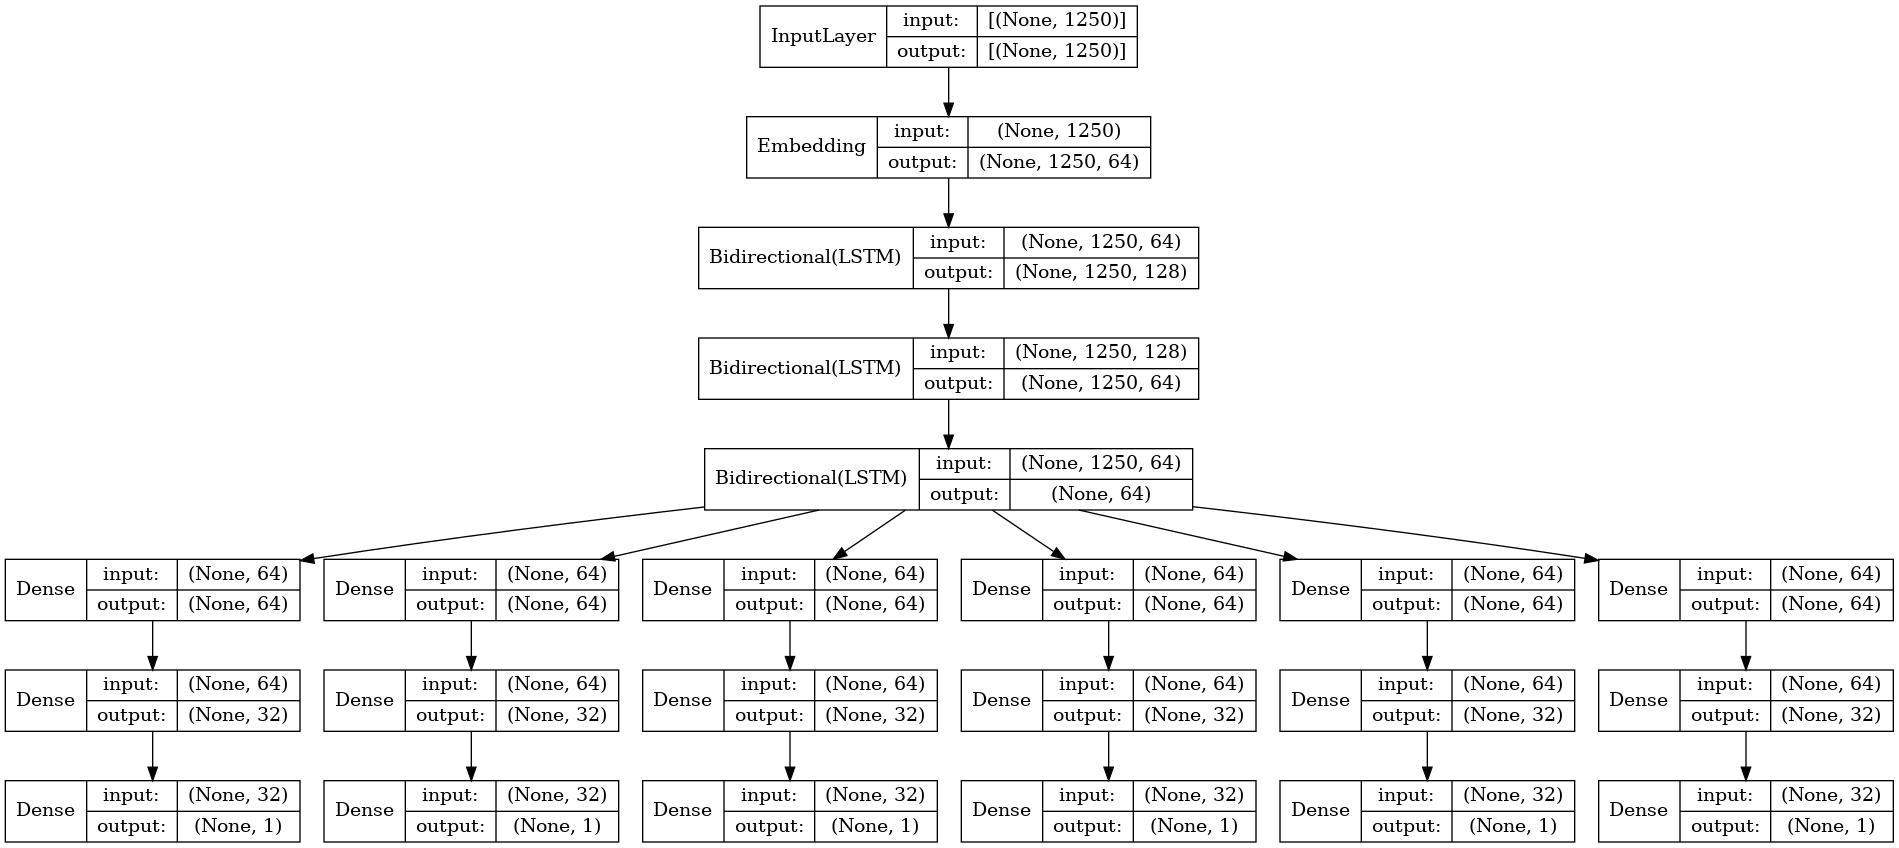

In [45]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, to_file="lstmmodel.png")

In [46]:
history = model.fit(X, y, epochs=50, validation_split=0.2, shuffle=True, verbose=1)

Epoch 1/50
196/196 [==============================] - 80s 363ms/step - loss: 6.9264 - cohesion_loss: 1.4004 - syntax_loss: 0.8567 - vocabulary_loss: 1.3936 - phraseology_loss: 0.8431 - grammar_loss: 0.9761 - conventions_loss: 1.4565 - val_loss: 2.5314 - val_cohesion_loss: 0.4439 - val_syntax_loss: 0.4064 - val_vocabulary_loss: 0.3342 - val_phraseology_loss: 0.4185 - val_grammar_loss: 0.5026 - val_conventions_loss: 0.4258
Epoch 2/50
196/196 [==============================] - 42s 214ms/step - loss: 2.6776 - cohesion_loss: 0.4511 - syntax_loss: 0.4440 - vocabulary_loss: 0.3531 - phraseology_loss: 0.4595 - grammar_loss: 0.5059 - conventions_loss: 0.4641 - val_loss: 2.6040 - val_cohesion_loss: 0.4405 - val_syntax_loss: 0.4388 - val_vocabulary_loss: 0.3333 - val_phraseology_loss: 0.4459 - val_grammar_loss: 0.4939 - val_conventions_loss: 0.4515
Epoch 3/50
196/196 [==============================] - 43s 217ms/step - loss: 2.4657 - cohesion_loss: 0.4204 - syntax_loss: 0.3990 - vocabulary_loss: 0

## Saving LSTM Model

In [47]:
model.save('lstm_model.h5')

## Inference with LSTM

In [58]:
X_test = pad_test
results = model.predict(X_test)
lstm_submission = pd.DataFrame()
lstm_submission['text_id'] = test_df['text_id']
for i in range(6):
    lstm_submission[i] = pd.Series([float(x) for x in results[i]])
lstm_submission.columns = train_df.drop(columns=['full_text', 'num_words']).columns
lstm_submission = lstm_submission.clip(upper=pd.Series({'cohesion':4.0, 'syntax':4.0, 'vocabulary':4.0, 'phraseology':4.0, 'grammar':4.0, 'conventions':4.0}), axis=1)
lstm_submission['text_id'] = test_df['text_id']

lstm_submission.head()

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.323423,2.860560,2.898727,2.823245,2.493071,2.357811
1,000BAD50D026,3.948826,4.000000,3.770655,3.889463,3.953792,4.000000
2,00367BB2546B,3.414649,3.181188,3.485476,3.524958,2.724504,2.771272


In [61]:
lstm_submission.to_csv('lstmsubmission.csv', index=False)

## Release Memory

In [64]:
import gc
del lstm_submission, model
gc.collect()

6604

## Modeling with Transformers

The paper ‘Attention Is All You Need’ introduces a novel architecture called Transformer. As the title indicates, it uses the attention-mechanism we saw earlier. Like LSTM, Transformer is an architecture for transforming one sequence into another one with the help of two parts (Encoder and Decoder), but it differs from the previously described/existing sequence-to-sequence models because it does not imply any Recurrent Networks (GRU, LSTM, etc.).

Recurrent Networks were, until now, one of the best ways to capture the timely dependencies in sequences. However, the team presenting the paper proved that an architecture with only attention-mechanisms without any RNN (Recurrent Neural Networks) can improve on the results in translation task and other tasks! One improvement on Natural Language Tasks is presented by a team introducing BERT: BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding.

<img src=https://www.researchgate.net/publication/344197785/figure/fig2/AS:934416989843456@1599793779015/Transformer-model-architecture-described-in-Attention-Is-All-You-Need-6.ppm/>

The Encoder is on the left and the Decoder is on the right. Both Encoder and Decoder are composed of modules that can be stacked on top of each other multiple times, which is described by Nx in the figure. We see that the modules consist mainly of Multi-Head Attention and Feed Forward layers. The inputs and outputs (target sentences) are first embedded into an n-dimensional space since we cannot use strings directly.

One slight but important part of the model is the positional encoding of the different words. Since we have no recurrent networks that can remember how sequences are fed into a model, we need to somehow give every word/part in our sequence a relative position since a sequence depends on the order of its elements. These positions are added to the embedded representation (n-dimensional vector) of each word.

<img src=https://lh4.googleusercontent.com/DC_rDdiH4QOskCm1C8--JMdAx_aj1bdekU11AYvJSQQwEJvoKfRZ7Bv8UjUuXhmfWmGcw1aSo4R_O62J2aZultJF9Jk_1R30gY77PNzCeijzMkrbDzgqR9iyo5pbbIMm7Enyw0A />

Let’s start with the left description of the attention-mechanism. It’s not very complicated and can be described by the following equation:

<img src=https://i0.wp.com/kikaben.com/wp-content/uploads/2022/04/image-416.png />

Q is a matrix that contains the query (vector representation of one word in the sequence), K are all the keys (vector representations of all the words in the sequence) and V are the values, which are again the vector representations of all the words in the sequence. For the encoder and decoder, multi-head attention modules, V consists of the same word sequence than Q. However, for the attention module that is taking into account the encoder and the decoder sequences, V is different from the sequence represented by Q.

This means that the weights a are defined by how each word of the sequence (represented by Q) is influenced by all the other words in the sequence (represented by K). Additionally, the SoftMax function is applied to the weights a to have a distribution between 0 and 1. Those weights are then applied to all the words in the sequence that are introduced in V (same vectors than Q for encoder and decoder but different for the module that has encoder and decoder inputs).

The righthand picture describes how this attention-mechanism can be parallelized into multiple mechanisms that can be used side by side. The attention mechanism is repeated multiple times with linear projections of Q, K and V. This allows the system to learn from different representations of Q, K and V, which is beneficial to the model. These linear representations are done by multiplying Q, K and V by weight matrices W that are learned during the training.

Those matrices Q, K and V are different for each position of the attention modules in the structure depending on whether they are in the encoder, decoder or in-between encoder and decoder. The reason is that we want to attend on either the whole encoder input sequence or a part of the decoder input sequence. The multi-head attention module that connects the encoder and decoder will make sure that the encoder input-sequence is taken into account together with the decoder input-sequence up to a given position.

After the multi-attention heads in both the encoder and decoder, we have a pointwise feed-forward layer. This little feed-forward network has identical parameters for each position, which can be described as a separate, identical linear transformation of each element from the given sequence.

## Deberta v3 model 

<img src=https://analyticsdrift.com/wp-content/uploads/2021/01/Microsoft-DeBERTa.jpg width=700/>

DeBERTa (Decoding-enhanced BERT with disentangled attention) is a large scale pre-trained language model which improves the BERT and RoBERTa models using two novel techniques. The first is the disentangled attention mechanism, where each word is represented using two vectors that encode its content and position, respectively, and the attention weights among words are computed using disentangled matrices on their contents and relative positions. Second, an enhanced mask decoder is used to replace the output softmax layer to predict the masked tokens for model pretraining. We show that these two techniques significantly improve the efficiency of model pre-training and performance of downstream tasks.

Unlike BERT where each word in the input layer is represented using
a vector which is the sum of its word (content) embedding and position embedding, each word in
DeBERTa is represented using two vectors that encode its content and position, respectively, and the
attention weights among words are computed using disentangled matrices based on their contents
and relative positions, respectively. This is motivated by the observation that the attention weight of a
word pair depends on not only their contents but their relative positions. For example, the dependency
between the words “deep” and “learning” is much stronger when they occur next to each other than
when they occur in different sentences.

<a href='https://www.microsoft.com/en-us/research/publication/deberta-decoding-enhanced-bert-with-disentangled-attention-2/'>Check this for more INFO!</a>

In [18]:
checkpoint = "microsoft/deberta-v3-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
debertamodel = TFAutoModel.from_pretrained(checkpoint, output_hidden_states=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.7/site-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
All model checkpoint layers were used when initializing TFDebertaV2Model.

All the layers of TFDebertaV2Model were initialized from the model checkpoint at microsoft/deberta-v3-s

In [19]:
tokenizer.save_pretrained('./tokenizer/')

('./tokenizer/tokenizer_config.json',
 './tokenizer/special_tokens_map.json',
 './tokenizer/spm.model',
 './tokenizer/added_tokens.json',
 './tokenizer/tokenizer.json')

In [6]:
def deberta_encode(texts, tokenizer=tokenizer):
    input_ids = []
    attention_mask = []
    
    for text in texts.tolist():
        token = tokenizer(text, 
                          add_special_tokens=True, 
                          max_length=512, 
                          return_attention_mask=True, 
                          return_tensors="np", 
                          truncation=True, 
                          padding='max_length')
        input_ids.append(token['input_ids'][0])
        attention_mask.append(token['attention_mask'][0])
    
    return np.array(input_ids, dtype="int32"), np.array(attention_mask, dtype="int32")

def get_dataset(df):
    inputs = deberta_encode(df['full_text'])
    targets = np.array(df[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']], dtype="float32")
    return inputs, targets

In [7]:
train_dataset = get_dataset(train_df)

In [8]:
def get_tf_model():
    input_ids = tf.keras.layers.Input(
        shape=(512,), dtype=tf.int32, name="input_ids"
    )
    
    attention_masks = tf.keras.layers.Input(
        shape=(512,), dtype=tf.int32, name="attention_masks"
    )
   
    deberta_output = debertamodel.deberta(
        input_ids, attention_mask=attention_masks
    )
    
    last_hidden_statee = deberta_output.last_hidden_state
    
    x = tf.keras.layers.GlobalAveragePooling1D()(last_hidden_statee)
    x = tf.keras.layers.Dense(6, activation='sigmoid')(x)
    output = tf.keras.layers.Rescaling(scale=4.0, offset=1.0)(x)
    tfmodel = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=output)
    tfmodel.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss = tf.keras.losses.mean_squared_error
    )
    return tfmodel

In [9]:
tfmodel = get_tf_model()

In [10]:
tfmodel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 512)]        0                                            
__________________________________________________________________________________________________
deberta (TFDebertaV2MainLayer)  TFBaseModelOutput(la 141304320   input_ids[0][0]                  
                                                                 attention_masks[0][0]            
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 768)          0           deberta[0][7]                

In [14]:
 tfhistory = tfmodel.fit(x=train_dataset[0],
                         y=train_dataset[1],
                         validation_split=0.2, 
                         epochs=10,
                         batch_size=8
                        )

Epoch 1/10
391/391 [==============================] - 281s 719ms/step - loss: 0.4592 - val_loss: 0.4106
Epoch 2/10
391/391 [==============================] - 278s 710ms/step - loss: 0.4406 - val_loss: 0.3892
Epoch 3/10
391/391 [==============================] - 278s 711ms/step - loss: 0.4355 - val_loss: 0.4220
Epoch 4/10
391/391 [==============================] - 278s 710ms/step - loss: 0.4443 - val_loss: 0.4101
Epoch 5/10
391/391 [==============================] - 278s 710ms/step - loss: 0.4285 - val_loss: 0.4106
Epoch 6/10
391/391 [==============================] - 278s 711ms/step - loss: 0.4295 - val_loss: 0.4021
Epoch 7/10
391/391 [==============================] - 279s 713ms/step - loss: 0.4270 - val_loss: 0.3974
Epoch 8/10
391/391 [==============================] - 279s 713ms/step - loss: 0.4242 - val_loss: 0.3938
Epoch 9/10
391/391 [==============================] - 278s 711ms/step - loss: 0.4223 - val_loss: 0.3952
Epoch 10/10
391/391 [==============================] - 279s 713m

## Inference with DeBerta Model

In [17]:
test_dataset = deberta_encode(test_df['full_text'])

pred = tfmodel.predict(test_dataset, batch_size=8)

tf_submission = pd.concat([test_df[['text_id']], pd.DataFrame(pred, columns=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'])], axis=1)
tf_submission.head()
tf_submission.to_csv('tfsubmission.csv', index=False)